[08:41:20] WARNING: not removing hydrogen atom without neighbors
[08:41:20] WARNING: not removing hydrogen atom without neighbors


Epoch 1/150, Loss: 0.5487, Accuracy: 0.7897
Epoch 1/150, Loss: 0.5487, Accuracy: 0.7897
Epoch 2/150, Loss: 0.4802, Accuracy: 0.7947
Epoch 2/150, Loss: 0.4802, Accuracy: 0.7947
Epoch 3/150, Loss: 0.4433, Accuracy: 0.8026
Epoch 3/150, Loss: 0.4433, Accuracy: 0.8026
Epoch 4/150, Loss: 0.4059, Accuracy: 0.8224
Epoch 4/150, Loss: 0.4059, Accuracy: 0.8224
Epoch 5/150, Loss: 0.3769, Accuracy: 0.8427
Epoch 5/150, Loss: 0.3769, Accuracy: 0.8427
Epoch 6/150, Loss: 0.3427, Accuracy: 0.8598
Epoch 6/150, Loss: 0.3427, Accuracy: 0.8598
Epoch 7/150, Loss: 0.3084, Accuracy: 0.8741
Epoch 7/150, Loss: 0.3084, Accuracy: 0.8741
Epoch 8/150, Loss: 0.2855, Accuracy: 0.8847
Epoch 8/150, Loss: 0.2855, Accuracy: 0.8847
Epoch 9/150, Loss: 0.2622, Accuracy: 0.9013
Epoch 9/150, Loss: 0.2622, Accuracy: 0.9013
Epoch 10/150, Loss: 0.2386, Accuracy: 0.9068
Epoch 10/150, Loss: 0.2386, Accuracy: 0.9068
Epoch 11/150, Loss: 0.2228, Accuracy: 0.9184
Epoch 11/150, Loss: 0.2228, Accuracy: 0.9184
Epoch 12/150, Loss: 0.2060, 

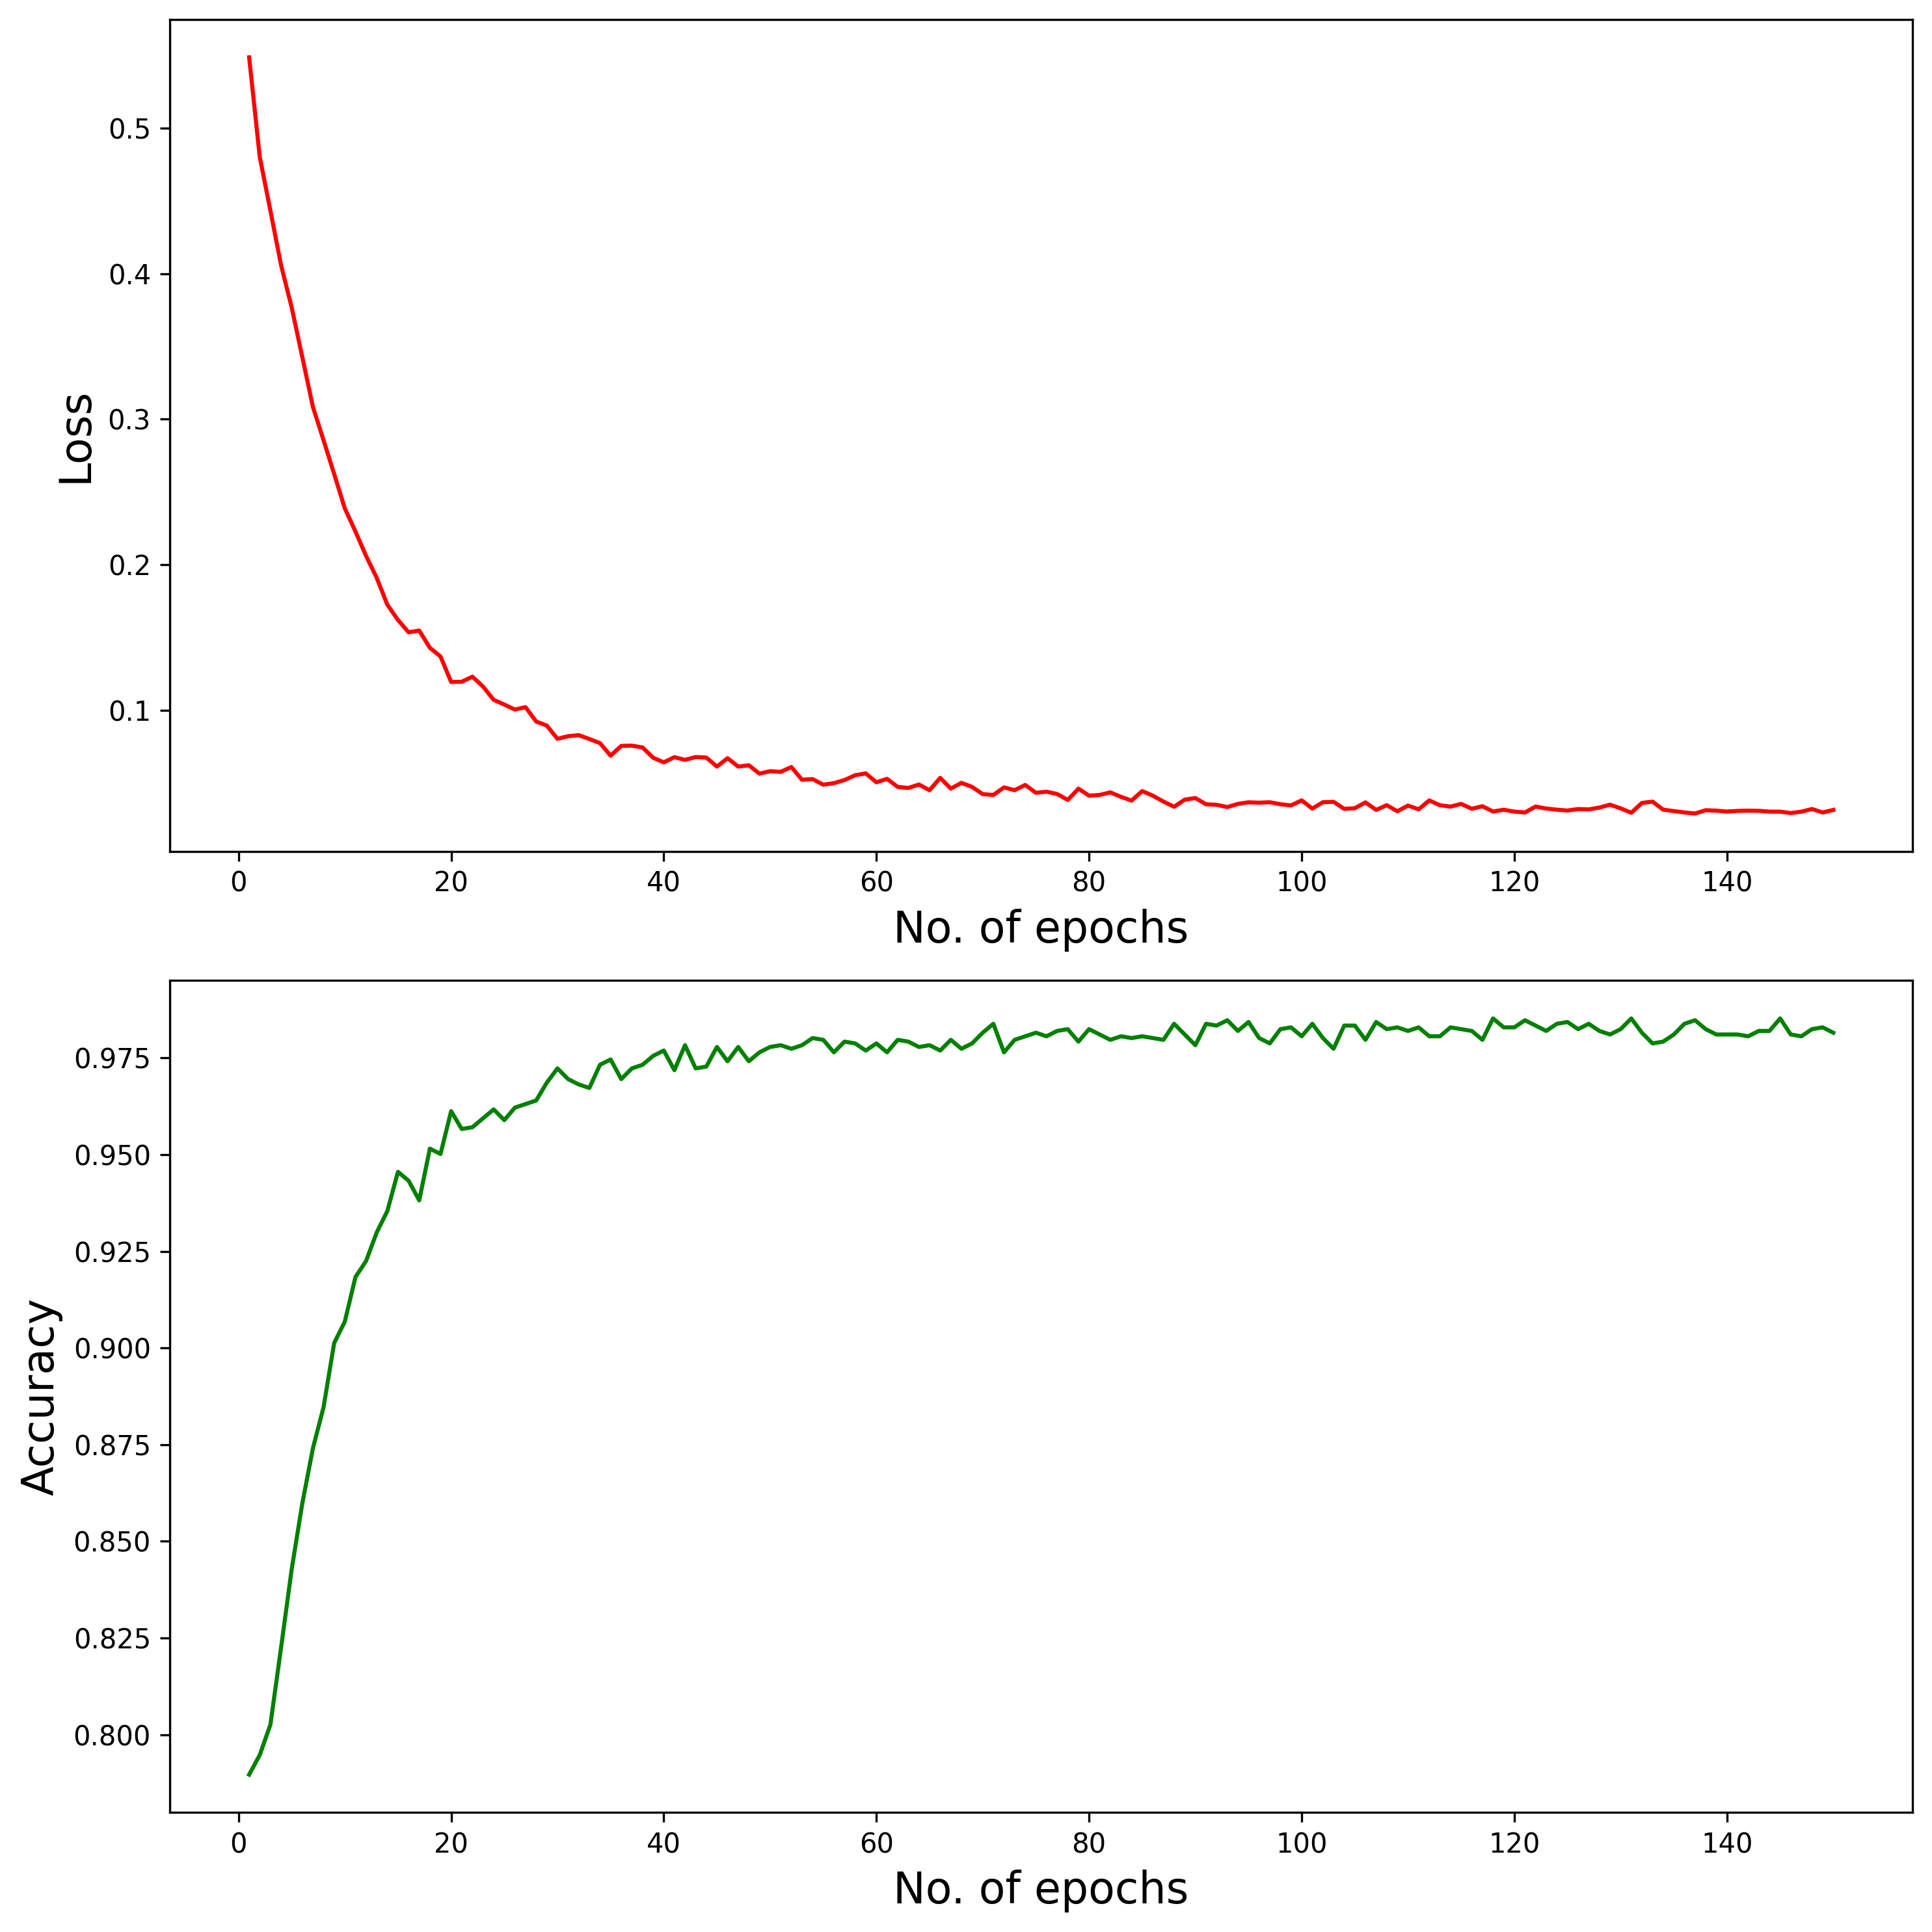

MAE: 0.1759747910587103
Accuracy: 0.8237179487179487


In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, mean_absolute_error, accuracy_score, matthews_corrcoef, cohen_kappa_score, brier_score_loss
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from rdkit import Chem
from rdkit.Chem import AllChem
import numpy as np
import matplotlib.pyplot as plt

# Read data from Excel file
data_train = pd.read_excel("train_smiles_label.xlsx")
data_test = pd.read_csv("externalshiamiles.csv")

# Preprocess the SMILES strings
def preprocess_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)
    if mol is None:
        return None
    Chem.SanitizeMol(mol)
    return mol

#Preparation of training set

data_train['Molecule'] = data_train['smiles'].apply(preprocess_smiles)
data_train = data_train.dropna()
data_train['Fingerprint'] = data_train['Molecule'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
X_train = torch.tensor(data_train['Fingerprint'].tolist(), dtype=torch.float32)
y_train = torch.tensor(data_train['Target'].values, dtype=torch.float32)

#Preparation of test set

data_test['Molecule'] = data_test['smiles'].apply(preprocess_smiles)
data_test = data_test.dropna()
data_test['Fingerprint'] = data_test['Molecule'].apply(lambda x: AllChem.GetMorganFingerprintAsBitVect(x, 2, nBits=1024))
X_test = torch.tensor(data_test['Fingerprint'].tolist(), dtype=torch.float32)
y_test = torch.tensor(data_test['Target'].values, dtype=torch.float32)

# Define the GCNN model
class GCNN(nn.Module):
    def __init__(self):
        super(GCNN, self).__init__()
        self.fc1 = nn.Linear(1024, 64)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return x

# Initialize the model
model = GCNN()

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters())

# Create DataLoader for training and testing

train_dataset = TensorDataset(X_train, y_train)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size=32)

# Initialize lists to store values
train_losses = []
train_accuracies = []
test_aucs = []

# Training the model
num_epochs = 150
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0
    
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs.squeeze(), labels)
        loss.backward()
        optimizer.step()
        
        # Compute accuracy
        predictions = (outputs > 0.5).squeeze().int()
        correct_predictions += (predictions == labels).sum().item()
        total_samples += labels.size(0)
        
        # Compute running loss
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_accuracy = correct_predictions / total_samples    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")

# Store values for plotting
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}")
    
# Plotting loss and accuracy as subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 10), dpi=300)

# Plot training loss
ax1.plot(np.arange(1, num_epochs + 1), train_losses, color= 'red', label='Training Loss')
ax1.set_xlabel('No. of epochs', fontsize=16)
ax1.set_ylabel('Loss',fontsize=16)

# Plot training accuracy
ax2.plot(np.arange(1, num_epochs + 1), train_accuracies, color= 'green', label='Training Accuracy')
ax2.set_xlabel('No. of epochs',fontsize=16)
ax2.set_ylabel('Accuracy',fontsize=16)
#ax2.set_title('Training Accuracy')

# Adjust layout and show plot
plt.tight_layout()
plt.savefig("GCNN_Traing_Loss_Acc.png")
plt.show()

# Evaluation with hold out test set

model.eval()
predictions = []
with torch.no_grad():
    for inputs, _ in test_loader:
        outputs = model(inputs)
        predictions.extend(outputs.squeeze().tolist())
        
#auc = roc_auc_score(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)
accuracy = accuracy_score(y_test, (torch.tensor(predictions) > 0.5).int())

#print("AUC:", auc)
print("MAE:", mae)
print("Accuracy:", accuracy)